# LAB 10. Recommender Systems

In this assignment, we'll learn how to implement recommender system using collaborative filtering approach.

![](intro.png)

## Outline
Click on these links to jump to a particular section of this assignment.
- [1. Collaborative Filtering: Matrix Factorization](#1)
- [2. YOUR TOURN](#2)
  

## References
- [Machine Learning. Week 9. Programming Ex.8](https://www.coursera.org/learn/machine-learning/)
- [arturomp/coursera-machine-learning-in-python](https://github.com/arturomp/coursera-machine-learning-in-python/tree/master/mlclass-ex8-004/mlclass-ex8)
- [Intro to Recommender Systems: Collaborative Filtering](https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/)
- [Various Implementations of Collaborative Filtering](https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0)
- [Recommender Systems — User-Based and Item-Based Collaborative Filtering](https://medium.com/@cfpinela/recommender-systems-user-based-and-item-based-collaborative-filtering-5d5f375a127f)
- [Beginner’s Recommendation Systems with Python](https://towardsdatascience.com/beginners-recommendation-systems-with-python-ee1b08d2efb6)
- [Item-based collaborative filtering](http://www.cs.carleton.edu/cs_comps/0607/recommend/recommender/itembased.html)


<a name="1"></a>
## 1. Collaborative Filtering: Matrix Factorization

In [1]:
# Load useful libraries
%matplotlib inline
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#  Load data
mat = scipy.io.loadmat('ex8_movies.mat')
Y = mat["Y"]
R = mat["R"]

print(f"Movies: {Y.shape[0]}\nUsers: {Y.shape[1]}")

mat

Movies: 1682
Users: 943


{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0',
 '__globals__': [],
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [2]:
# Compute average rating
print('Average rating for movie 1 (Toy Story): {:.3f} (out of 5)'.format(np.mean(Y[0, R[0, :] == 1])))

Average rating for movie 1 (Toy Story): 3.878 (out of 5)


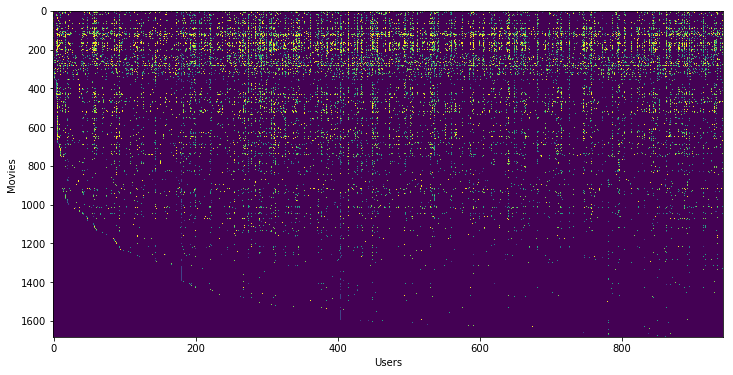

In [3]:
# Visualize the sparsity of the ratings matrix
fig = plt.figure(figsize=(12,6))
plt.imshow(Y, aspect='auto') 
plt.ylabel('Movies')
plt.xlabel('Users')
plt.show(block=False)

In [4]:
# Load pre-trained weights and other parameters
mat = scipy.io.loadmat('ex8_movieParams.mat')
X = mat["X"]
Theta = mat["Theta"]
num_users = mat["num_users"]
num_movies = mat["num_movies"]
num_features = mat["num_features"]

mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:16:53 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[ 1.0486855 , -0.40023196,  1.19411945, ...,  0.861721  ,
         -0.69728994,  0.28874563],
        [ 0.78085123, -0.38562591,  0.52119779, ...,  0.70402073,
         -0.48583521, -0.56462407],
        [ 0.64150886, -0.54785385, -0.08379638, ...,  0.83854643,
         -0.69483208, -1.13479631],
        ...,
        [ 0.21952237, -0.20047886,  0.09257965, ...,  0.14595183,
         -0.0431316 ,  0.17830451],
        [ 0.16044028, -0.16015395,  0.23570946, ...,  0.2073381 ,
         -0.33234766,  0.0428813 ],
        [ 0.07677118, -0.19720738,  0.08186445, ...,  0.40012757,
         -0.28747906, -0.03233498]]),
 'Theta': array([[ 0.28544362, -1.68426509,  0.26293877, ...,  0.76723235,
         -1.10460164, -0.25186708],
        [ 0.50501321, -0.45464846,  0.31746244, ...,  1.09306336,
         -1.20029436, -0.39161676],
        [-0.4319

In [5]:
# Reduce the data set size so that this runs faster
num_users = 4 
num_movies = 5 
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

In [6]:
def cofi_cost_function(params, Y, R, num_users, num_movies, num_features, lambda_var):
    """
    : Collaborative filtering cost function
    : [J, grad] = COFICOSTFUNC(params, Y, R, num_users, num_movies, num_features, lambda) returns
    : the cost and gradient for the collaborative filtering problem.    
    :
    """

    # Unfold the U and W matrices from params
    X = np.reshape(params[ : num_movies * num_features], (num_movies, num_features), order='F')
    Theta = np.reshape(params[num_movies * num_features : ], (num_users, num_features), order='F')

    # Initialize some important parameters
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    # For cost function, sum only i,j for which R(i,j)=1
    J = (1/2.) * np.sum(np.power(np.dot(X, Theta.T) - Y, 2) * R)

    # Compute gradients
    X_grad = np.dot((np.dot(X, Theta.T) - Y ) * R, Theta)
    Theta_grad = np.dot(((np.dot(X, Theta.T) - Y ) * R).T, X)

    # Add regularization
    J = J + (lambda_var / 2.) * (np.sum(np.power(Theta, 2)) + np.sum(np.power(X, 2)))
    X_grad = X_grad + lambda_var * X
    Theta_grad = Theta_grad + lambda_var * Theta

    # Compute a gradient
    grad = np.concatenate((X_grad.reshape(X_grad.size, order='F'), Theta_grad.reshape(Theta_grad.size, order='F')))

    return J, grad

In [7]:
#  Evaluate cost function
params = np.concatenate((X.reshape(X.size, order='F'), Theta.reshape(Theta.size, order='F')))
J, _ = cofi_cost_function(params, Y, R, num_users, num_movies, num_features, 0)
           
print('Cost at loaded parameters: {:f}\n(this value should be about 22.22)'.format(J))

Cost at loaded parameters: 22.224604
(this value should be about 22.22)


In [8]:
# Check gradients
def compute_numerical_gradient(J, Theta):
    """
    : Computes the numerical gradient of the function J around Theta.
    : Calling y = J(Theta) shouldreturn the function value at Theta.
    """
    numgrad = np.zeros(Theta.shape)
    perturb = np.zeros(Theta.shape)
    e = 1e-4

    for p in range(Theta.size):
        # Set perturbation vector
        perturb.reshape(perturb.size, order="F")[p] = e
        loss1, _ = J(Theta - perturb)
        loss2, _ = J(Theta + perturb)
        
        # Compute Numerical Gradient
        numgrad.reshape(numgrad.size, order="F")[p] = (loss2 - loss1) / (2*e)
        perturb.reshape(perturb.size, order="F")[p] = 0
        
    return numgrad


def check_cost_function(lambda_var=0):
    """
    : Creates a collaborative filering problem to check your cost function and gradients,
    : it will output the analytical gradients produced by your code and the numerical
    : gradients (computed using compute_numerical_gradient()). These two gradient 
    : computations should result in very similar values.
    """

    # Set lambda_var
    # if not lambda_var or not 'lambda_var' in locals():
    #     lambda_var = 0

    ## Create small problem
    X_t = np.random.rand(4, 3)
    Theta_t = np.random.rand(5, 3)

    # Zap out most entries
    Y = np.dot(X_t, Theta_t.T)
    Y[np.random.rand(Y.shape[0], Y.shape[1]) > 0.5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1

    # Run gradient checking
    X = np.random.randn(X_t.shape[0], X_t.shape[1])
    Theta = np.random.randn(Theta_t.shape[0], Theta_t.shape[1])
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = Theta_t.shape[1]

    params = np.concatenate((X.reshape(X.size, order='F'), Theta.reshape(Theta.size, order='F')))

    # Short hand for cost function
    def cost_func(p):
        return cofi_cost_function(p, Y, R, num_users, num_movies, num_features, lambda_var)

    numgrad = compute_numerical_gradient(cost_func, params)

    cost, grad = cofi_cost_function(params, Y, R, num_users, num_movies, num_features, lambda_var)

    print(np.column_stack((numgrad, grad)))
    print('The above two columns you get should be very similar.\n' \
             '(Left-Your Numerical Gradient, Right-Analytical Gradient)')

    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)
    print('If your backpropagation implementation is correct, then \n' \
             'the relative difference will be small (less than 1e-9). ' \
             '\nRelative Difference: {:e}'.format(diff))


print('\nChecking Gradients (without regularization) ... \n')

check_cost_function()


Checking Gradients (without regularization) ... 

[[-6.89087478 -6.89087478]
 [-0.27313682 -0.27313682]
 [ 1.59572996  1.59572996]
 [ 0.12574513  0.12574513]
 [-0.03446713 -0.03446713]
 [-2.345415   -2.345415  ]
 [-4.16531794 -4.16531794]
 [-0.5101092  -0.5101092 ]
 [ 4.82176221  4.82176221]
 [-4.0501493  -4.0501493 ]
 [-2.34103216 -2.34103216]
 [-0.70237549 -0.70237549]
 [ 0.          0.        ]
 [ 6.20260949  6.20260949]
 [ 1.34561001  1.34561001]
 [-6.49654854 -6.49654854]
 [-0.25404136 -0.25404136]
 [ 0.          0.        ]
 [-5.32823873 -5.32823873]
 [ 2.43050541  2.43050541]
 [ 7.61452154  7.61452154]
 [-0.99682731 -0.99682731]
 [ 0.          0.        ]
 [-1.19497982 -1.19497982]
 [ 4.50852142  4.50852142]
 [ 0.5125595   0.5125595 ]
 [-1.52225332 -1.52225332]]
The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your backpropagation implementation is correct, then 
the relative difference will be small (less than 1

In [9]:
# Evaluate cost function
params = np.concatenate((X.reshape(X.size, order='F'), Theta.reshape(Theta.size, order='F')))
J, _ = cofi_cost_function(params, Y, R, num_users, num_movies, num_features, 1.5)
           
print('Cost at loaded parameters (lambda_var = 1.5): {:f} '\
         '\n(this value should be about 31.34)\n'.format(J))

Cost at loaded parameters (lambda_var = 1.5): 31.344056 
(this value should be about 31.34)



In [10]:
# Check gradients
print('\nChecking Gradients (with regularization) ... \n')

check_cost_function(1.5)


Checking Gradients (with regularization) ... 

[[ 8.14383452  8.14383452]
 [-6.48939527 -6.48939527]
 [ 7.84320348  7.84320348]
 [ 5.87465388  5.87465388]
 [ 6.01925314  6.01925314]
 [-5.05162453 -5.05162453]
 [ 1.28423335  1.28423335]
 [ 1.36113135  1.36113135]
 [ 2.11388701  2.11388701]
 [-2.04351645 -2.04351645]
 [ 6.64718363  6.64718363]
 [ 2.11455827  2.11455827]
 [ 2.46726162  2.46726162]
 [ 0.0463246   0.0463246 ]
 [-8.90679206 -8.90679206]
 [-0.43553545 -0.43553545]
 [11.48570139 11.48570139]
 [ 2.76335279  2.76335279]
 [-1.25507527 -1.25507527]
 [ 1.97401473  1.97401473]
 [-1.80782826 -1.80782826]
 [ 6.41551443  6.41551443]
 [ 0.06916337  0.06916337]
 [ 1.6239951   1.6239951 ]
 [-4.64241496 -4.64241496]
 [ 0.25810686  0.25810686]
 [-1.51109153 -1.51109153]]
The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your backpropagation implementation is correct, then 
the relative difference will be small (less than 1e-9

In [11]:
# Entering ratings for a new user

def load_movie_list():
    """
    : Reads the fixed movie list in movie.txt and returns a cell array of the words in movieList.
    """ 
    with open("movie_ids.txt") as movie_ids_file:
        # Store all movies in movie list
        n = 1682  # total number of movies 
        movie_list = [None] * n
        for i, line in enumerate(movie_ids_file.readlines()):
            movie_name = line.split()[1:]
            movie_list[i] = " ".join(movie_name)

    return movie_list


movie_list = load_movie_list()

#  Initialize my ratings
my_ratings = np.zeros((1682, 1))

# We have selected a few movies we liked / did not like and the ratings we gave are as follows:
my_ratings[0] = 5
my_ratings[11]= 5
my_ratings[63]= 4
my_ratings[68] = 3
my_ratings[97] = 4
my_ratings[225] = 3

print('\n\nNew user ratings:\n')
for i, rating in enumerate(my_ratings):
    if rating > 0: 
        print('Rated {:.0f} for {:s}'.format(rating[0], movie_list[i]))



New user ratings:

Rated 5 for Toy Story (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Shawshank Redemption, The (1994)
Rated 3 for Forrest Gump (1994)
Rated 4 for Silence of the Lambs, The (1991)
Rated 3 for Die Hard 2 (1990)


In [12]:
# Train the collaborative filtering model on a movie rating dataset of 1682 movies and 943 users
print('\nTraining collaborative filtering...\n')

def normalize_ratings(Y, R):
    """
    : Normalizes Y so that each movie has a rating of 0 on average, and returns the mean rating in Ymean.
    """
    m, n = Y.shape
    Ymean = np.zeros((m, 1))
    Ynorm = np.zeros(Y.shape)
    for i in range(m):
        idx = R[i, :] == 1
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]

    return Ynorm, Ymean


#  Load data
mat = scipy.io.loadmat('ex8_movies.mat')
Y = mat["Y"]
R = mat["R"]

#  Add our own ratings to the data matrix
Y = np.column_stack((my_ratings, Y))
R = np.column_stack(((my_ratings != 0).astype(int), R))

#  Normalize ratings
[Ynorm, Ymean] = normalize_ratings(Y, R)

#  Useful values
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

# Set initial parameters for Theta and X
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate((X.reshape(X.size, order='F'), Theta.reshape(Theta.size, order='F')))

# Set options
maxiter = 100
options = {'disp': True, 'maxiter': maxiter}
lambda_var = 10

# Create "short hand" for the cost function to be minimized
def cost_func(initial_parameters):
    return cofi_cost_function(initial_parameters, Ynorm, R, num_users, num_movies, num_features, lambda_var)

# Set regularization
results = minimize(cost_func, x0=initial_parameters, method="L-BFGS-B", jac=True, options=options)
theta = results["x"]

# Unfold the returned theta back into U and W
X = np.reshape(theta[ : num_movies * num_features], (num_movies, num_features), order='F')
Theta = np.reshape(theta[num_movies * num_features : ], (num_users, num_features), order='F')

print('Recommender system learning completed.\n')


Training collaborative filtering...

Recommender system learning completed.



In [13]:
# Recommendation for you
p = np.dot(X, Theta.T)
my_predictions = p[:,0] + Ymean.flatten()

movie_list = load_movie_list()

# from http://stackoverflow.com/a/16486305/583834 reverse sorting by index
ix = my_predictions.argsort()[::-1]

print('\n\nTop recommendations for you:\n')
for i in range(10):
    j = ix[i]
    print('Predicting rating {:.1f} for movie {:s}'.format(my_predictions[j], movie_list[j]))

print('\n\nOriginal ratings provided:')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated {:d} for {:s}'.format(int(my_ratings[i]), movie_list[i]))



Top recommendations for you:

Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)


Original ratings provided:
Rated 5 for Toy Story (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Shawshank Redemption, The (1994)
Rated 3 for Forrest Gump (1994)
Rated 4 for Silence of the Lambs, The (1991)
Rated 3 for Die Hard 2 (1990)


<a name="2"></a>
## 2. YOUR TOURN

1. After exploring the matrix factorization approach above, find some appropriate dataset.
2. Build your own recommender system using one of the following approaches:
  + content-based filtering
  + user-user collaborative filtering
  + item-item collaborative filtering